# Example: Reading tiled raster data with different zoom levels

This example will show how one can export raster dataset to individual tiles at differnt zoom levels and read the data via the [DataCatalog.get_rasterdataset](../_generated/hydromt.data_catalog.DataCatalog.get_rasterdataset.rst) method. 

In [1]:
from os.path import join

from hydromt import DataCatalog

# get some elevation data from the data catalog
data_lib = "artifact_data=v1.0.0"
data_cat = DataCatalog(data_lib)
source = "merit_hydro"
da0 = data_cat.get_rasterdataset(source, variables=["elevtn"])
da0.raster.shape

(1920, 1680)

`da0` is gridded data as an xarray.DataArray object. 
With HydroMT an xarray.DataArray has some extra functionality via `.raster`
This extra functionality does include the ability to write a raster to a tile database (tiling).


## Tiling raster with XYZ stucture

First let's have a look at the XYZ structure.
an xarray.DataArray is simple written to a tile database in XYZ structure via .raster.to_xyz_tiles



In [2]:
# Write the database in XYZ structure
name = f"{source}_xyz"
root = join("tmpdir", name)
zoom_levels = [0, 1, 2, 3, 4]
da0.raster.to_xyz_tiles(
    root=root,
    tile_size=256,
    zoom_levels=zoom_levels,
    gdal_driver="GTiff",  # try also 'netcdf4'
    compress="deflate",
)

Tiles at zoomlevel 4 smaller than tile_size 256


The tiles in the 'merit_hydro_xyz' folder now contains the zoom_levels as defined above. 

zoomlevel 0 is at the scale of the xarray.DataArray (one on one). zoomlevel 1 is downscaled by a factor 2 compared to zoomlevel 0. zoomlevel 3 is downscaled by a factor of 8 compared to zoomlevel 0, etc.

A mosaic is created per zoomlevel of these tiles in a .vrt file.

At last, a .yml file is produced which can be read by the [DataCatalog](../_generated/hydromt.data_catalog.DataCatalog.rst) of HydroMT.

## Tiling raster with OSM stucture

Now let's have a look at tiling according to the OSM structure
an xarray.DataArray is simple written to a tile database in OSM structure via ``.raster.to_slippy_tiles``

In [3]:
# Write the database in XYZ structure
name_osm = f"{source}_osm"
root_osm = join("tmpdir", name_osm)
da0.raster.to_slippy_tiles(
    root=root_osm,
    driver="GTiff",
    reproj_method="average",
    write_vrt=True,  # try also 'netcdf4'
)

The tiles in the 'merit_hydro_OSM' folder now contains all the zoom_levels from the minimal starting level (9) until the highest level (0).

Every tile, regardless of the zoomlevel, has a resolution of 256 by 256 pixels.

Zoomlevel 0 is at the scale of the entire world (one tile) and is the most downscaled. Zoomlevel 9 contains the highest resolution (most tiles) in regards to this tile database.

A mosaic is created per zoomlevel of these tiles in a .vrt file, if `write_vrt=True` (only applicable to nc and Gtiff files).
At last, if `write_vrt=True`,  a yaml file is produced which can be read by the [DataCatalog](../_generated/hydromt.data_catalog.DataCatalog.rst) of HydroMT.

## Tiling raster for a webviewer

Finally, let's take a look at tiling of a raster dataset with its use being to view the data in a webviewer.
This is easily done with the .raster.to_webviewer_tiles method. 


In [4]:
# Write the data in OSM structure, but to images!
from matplotlib import pyplot as plt

name_png = f"{source}_png"
root_png = join("tmpdir", name_png)
da0.raster.to_slippy_tiles(
    root=root_png,
)

Now that the images are created, let's take a look at an individual tile.

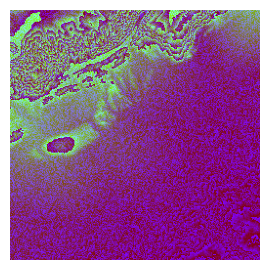

In [5]:
# View the data
from PIL import Image

# Create a figure to show the image
fig = plt.figure()
fig.set_size_inches(2.5, 2.5)
ax = fig.add_subplot(111)
ax.set_position([0, 0, 1, 1])
ax.axis("off")

# Show the image
im = Image.open(join(root_png, "9", "273", "182.png"))
ax.imshow(im)

The image itself tends to look like an oil painting, but this is correct.

The colors for this image are determined so that they are correctly visually represented according to Terrarium Terrain RGB.

If one were to see what this would look like in e.g. QGIS, a local sever is needed. 
With python this is easily done with the command `python -m http.server 8000` from the command line while within the folder where the tiles are located. In this case that would be 'root_png'.
In QGIS, make a new XYZ Tiles connection. For this new connection the URL becomes 'http://localhost:8000/{z}/{x}/{y}.png' and the interpolation is set to Terrarium Terrain RGB.

However, if the images are meant to be viewed as is, then a custom colormap can be defined to make them look nice!

Let's make another dataset of png's!


In [6]:
from matplotlib import pyplot as plt

name_png_cmap = f"{source}_png_cmap"
root_png_cmap = join("tmpdir", name_png_cmap)
# let us define a nice color for a terrain image
da0.raster.to_slippy_tiles(
    root=root_png_cmap,
    cmap="terrain",
    norm=plt.Normalize(vmin=0, vmax=2000),
)

Now lets take a look at the improved standard visuals!

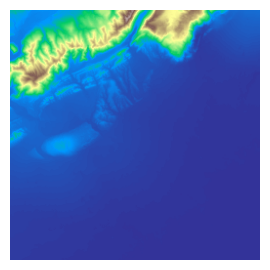

In [7]:
# View the data
import matplotlib.pyplot as plt
from PIL import Image

# Create a figure to show the image
fig = plt.figure()
fig.set_size_inches(2.5, 2.5)
ax = fig.add_subplot(111)
ax.set_position([0, 0, 1, 1])
ax.axis("off")

# Show the image
im = Image.open(join(root_png_cmap, "9", "273", "182.png"))
ax.imshow(im)

## Reading tiled raster data with zoom levels

With [DataCatalog.get_rasterdataset](../_generated/hydromt.data_catalog.DataCatalog.get_rasterdataset.rst) a raster (.vrt) can be retrieved. In case of a tile database it can be done for a certain zoomlevel. E.g.

In [8]:
from hydromt import DataCatalog

# Load the yml into a DataCatalog
data_catalog = DataCatalog(
    [join(root, f"{name}.yml"), join(root_osm, f"{name_osm}.yml")]
)

# View the structure of the DataCatalog
data_catalog.get_source(name)

RasterDatasetSource(name='merit_hydro_xyz', uri='merit_hydro_xyz_zl{overview_level}.vrt', data_adapter=RasterDatasetAdapter(unit_add={}, unit_mult={}, rename={}), driver=RasterioDriver(filesystem=<fsspec.implementations.local.LocalFileSystem object at 0x78e12a5c4310>, options={}), uri_resolver=ConventionResolver(filesystem=<fsspec.implementations.local.LocalFileSystem object at 0x78e12a5c4310>, options={}), root='tmpdir/merit_hydro_xyz', version=None, provider=None, metadata=SourceMetadata(crs=<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich
, unit=None, extent={}, nodata=-9999.0, attrs={}, category=None, zls_dict={0: 0.0008333333333333345, 1: 0.0016666666666666572, 2: 0.003333333333333316, 3: 0.006666666666666611, 4: 0.0133333333

In [9]:
# For the osm dataset
data_catalog.get_source(name_osm)

RasterDatasetSource(name='merit_hydro_osm', uri='lvl{overview_level}.vrt', data_adapter=RasterDatasetAdapter(unit_add={}, unit_mult={}, rename={}), driver=RasterioDriver(filesystem=<fsspec.implementations.local.LocalFileSystem object at 0x78e12a5c4310>, options={}), uri_resolver=ConventionResolver(filesystem=<fsspec.implementations.local.LocalFileSystem object at 0x78e12a5c4310>, options={}), root='tmpdir/merit_hydro_osm', version=None, provider=None, metadata=SourceMetadata(crs=<Projected CRS: EPSG:3857>
Name: WGS 84 / Pseudo-Mercator
Axis Info [cartesian]:
- X[east]: Easting (metre)
- Y[north]: Northing (metre)
Area of Use:
- name: World between 85.06°S and 85.06°N.
- bounds: (-180.0, -85.06, 180.0, 85.06)
Coordinate Operation:
- name: Popular Visualisation Pseudo-Mercator
- method: Popular Visualisation Pseudo Mercator
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich
, unit=None, extent={}, nodata=None, attrs={}, category=None, zls_dict={11:

In [10]:
# without zoom_level the highest res data is fetched
da0 = data_catalog.get_rasterdataset(name)
da0.raster.shape

(2048, 1792)

In [11]:
# And for OSM
da1 = data_catalog.get_rasterdataset(name_osm, zoom=11, geom=da0.raster.box)
da1.raster.shape

object: ConventionResolver does not use kwarg mask with value                                             geometry
0  POLYGON ((11.6 46.8, 11.6 45.09333, 13.09333 4....


nodata value missing for /home/sam/.hydromt/lvl11/lvl11.vrt


(3575, 2050)

In [12]:
# Request a raster from the Datacatolog based on zoom resolution & unit
da = data_catalog.get_rasterdataset(name_osm, zoom=(1 / 600, "degree"))
da = data_catalog.get_rasterdataset(name_osm, zoom=(1e4, "meter"))

nodata value missing for /home/sam/.hydromt/lvl10/lvl10.vrt


nodata value missing for /home/sam/.hydromt/lvl7/lvl7.vrt


In [13]:
# We can also directly request a specific zoom level
da = data_catalog.get_rasterdataset(name, zoom=zoom_levels[-1], geom=da0.raster.box)
print(da.raster.shape)

object: ConventionResolver does not use kwarg mask with value                                             geometry
0  POLYGON ((11.6 46.8, 11.6 45.09333, 13.09333 4....


(128, 112)


Text(0.5, 1.0, 'zoomlevel 4')

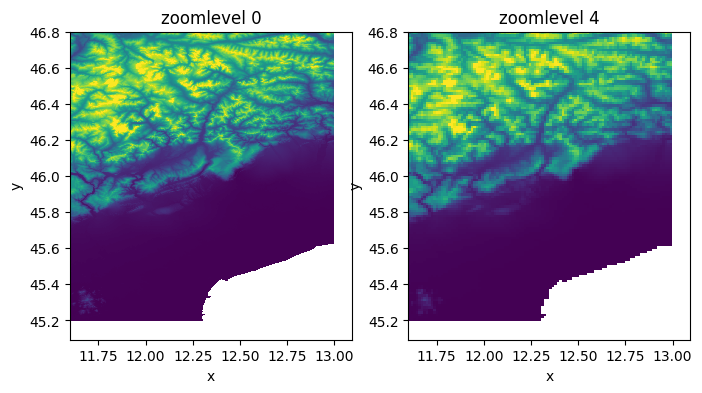

In [14]:
# View the data
import matplotlib.pyplot as plt

fig, (ax, ax1) = plt.subplots(1, 2, figsize=(8, 4))
da0.raster.mask_nodata().plot.imshow(ax=ax, vmin=0, vmax=2500, add_colorbar=False)
ax.set_title(f"zoomlevel {zoom_levels[0]}")
da.raster.mask_nodata().plot.imshow(ax=ax1, vmin=0, vmax=2500, add_colorbar=False)
ax1.set_title(f"zoomlevel {zoom_levels[-1]}")

## Caching tiled raster datasets

Tiles of tiled rasterdatasets which are described by a .vrt file can be cached locally (starting from v0.7.0). 
The requested data tiles will by default be stored to ~/.hydromt_data.

In [15]:
# set caching to True
# NOTE this can also be done at initialization of the DataCatalog
data_catalog.cache = True

# request some tiles based on bbox -> note the log messages
da0 = data_catalog.get_rasterdataset(name, bbox=[11.6, 45.3, 12.0, 46.0])

object: ConventionResolver does not use kwarg mask with value                                             geometry
0  POLYGON ((12 45.3, 12 46, 11.6 46, 11.6 45.3, ....


In [16]:
# if we run the same request again we will use the cached files (and download none)
da0 = data_catalog.get_rasterdataset(name, bbox=[11.6, 45.3, 12.0, 46.0])

object: ConventionResolver does not use kwarg mask with value                                             geometry
0  POLYGON ((12 45.3, 12 46, 11.6 46, 11.6 45.3, ....
